# 3. Modelos de clasificación y evaluación comparativa

## 3.1 Enfoque de modelado supervisado

Se quiere **predecir con alta sensibilidad (recall)** si un caso notificado de dengue en Colombia corresponde a un **caso confirmado positivo**.

Se trata de un **problema de clasificación binaria**, en el cual la variable objetivo toma el valor:

* **1**: para los casos confirmados positivos de dengue.
* **0**: para los casos descartados, indeterminados o sospechosos.

El enfoque adoptado es el de **aprendizaje supervisado**, en el cual los modelos son entrenados a partir de datos históricos etiquetados para aprender patrones que permitan predecir nuevos casos.

**✅ Criterio de evaluación**

Dado que en el contexto de salud pública **los falsos negativos representan un riesgo crítico**, se prioriza la métrica de **recall (sensibilidad)** como criterio principal. Es decir, se busca maximizar la proporción de casos positivos correctamente identificados por el modelo.

Se complementa esta evaluación con otras métricas como:

* **F1 Score**: para balancear recall y precisión.
* **Área bajo la curva ROC (AUC)**: para evaluar la capacidad general de discriminación.
* **Matriz de confusión**: para observar la distribución de errores (falsos positivos y falsos negativos).

## 3.2 Preparación de los datos

Antes de entrenar los modelos de clasificación, se aplicaron varios pasos de transformación y codificación de variables, con el fin de preparar el conjunto de datos para el aprendizaje supervisado.

In [1]:
# Librerias

# Estandar
import time
import os 
os.environ["LOKY_MAX_CPU_COUNT"] = "8" 

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento
import numpy as np
import pandas as pd
import scipy.stats as stats

# Adicionales
import time
from lime.lime_tabular import LimeTabularExplainer
import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image, display

In [2]:
# Librerias de modelado

# Procesamiento de datos
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

# Division de datos
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV)

# Modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Evaluación de modelos
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    f1_score,
    recall_score, precision_recall_curve, average_precision_score)

# Balanceo
from imblearn.over_sampling import SMOTE

🔹 **Lectura de datos** \
Los datos fueron leídos desde un archivo en formato .csv y estos no presentan datos perdidos.

🔸 **Codificación de variables categóricas** \
Las variables `TIP_SS` (tipo de aseguradora) y `EVENTO` (tipo de evento notificado) fueron codificadas utilizando One-Hot Encoding, eliminando la primera categoría con drop_first=True para evitar multicolinealidad entre variables.

🔸 **Reemplazo por frecuencia relativa**\
Las variables categóricas con alta cardinalidad geográfica, como `PAIS_OCU`, `DPTO_OCU` y `MUN_OCU`, fueron transformadas en valores de frecuencia relativa. Es decir, cada categoría fue reemplazada por la proporción de ocurrencia de esa categoría en el dataset.

Esto permite representar información geográfica útil sin introducir un número elevado de columnas que puedan afectar la generalización del modelo.

🔸 **Normalización de variables numéricas**\
La variable `EDAD_AJUSTADA` fue estandarizada mediante escalado z-score, lo que garantiza que tenga media 0 y desviación estándar 1, mejorando el desempeño de modelos sensibles a la escala de los datos.

In [3]:
# Lectura de datos
df = pd.read_csv(r"C:\Users\Hp\MACHINE\data\registros_dengue.csv")
df = df.drop(columns=['TIP_CAS'])

# Ajuste de edades menores a un año (Representación de en días, semanas o meses, variable que representa años)
df.loc[df["EDAD_AJUSTADA"] < 1, "EDAD_AJUSTADA"] = 1 
df.loc[df["EDAD_AJUSTADA"] > 114, "EDAD_AJUSTADA"] = np.nan

# Reemplazo de NA en la variable EDAD_AJUSTADA por la mediana de la variable
mediana_eda = df['EDAD_AJUSTADA'].median()
df.loc[:, 'EDAD_AJUSTADA'] = df['EDAD_AJUSTADA'].fillna(mediana_eda)

# ajuste de tipos de datos
df.loc[:,'EDAD_AJUSTADA'] = df['EDAD_AJUSTADA'].astype('int64')

In [4]:
# Codificación One-Hot para las variables categóricas 
# 'TIP_SS' (Tipo aseguradora) y 'EVENTO'
# Se usa drop_first=True para evitar multicolinealidad eliminando la primera categoría
df = pd.get_dummies(df, columns=['TIP_SS', 'EVENTO'], drop_first=True)

# Transformación de 'PAIS_OCU', 'DPTO_OCU' y 'MUN_OCU' a valores de frecuencia relativa
# Se reemplazan las categorías por la proporción de ocurrencias en el dataset
for col in ['PAIS_OCU', 'DPTO_OCU', 'MUN_OCU']:
    freq = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].map(freq).fillna(0).astype('float64')

# Normalización de la variable numérica 'EDAD_AJUSTADA'
# Se estandariza para que tenga media 0 y desviación estándar 1
scaler = StandardScaler()
df['EDAD_AJUSTADA'] = scaler.fit_transform(df[['EDAD_AJUSTADA']])

🔹 **Variables de estudio**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947280 entries, 0 to 947279
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   EDAD_AJUSTADA        947280 non-null  float64
 1   GP_MIGRANT           947280 non-null  int64  
 2   GP_POBICFB           947280 non-null  int64  
 3   GP_GESTAN            947280 non-null  int64  
 4   AREA                 947280 non-null  int64  
 5   PAIS_OCU             947280 non-null  float64
 6   DPTO_OCU             947280 non-null  float64
 7   MUN_OCU              947280 non-null  float64
 8   SEMANA               947280 non-null  int64  
 9   ANO                  947280 non-null  int64  
 10  PAC_HOS              947280 non-null  int64  
 11  CON_FIN              947280 non-null  int64  
 12  CONFIRMADOS          947280 non-null  int64  
 13  SEXO_NUM             947280 non-null  int64  
 14  TIP_SS_E             947280 non-null  bool   
 15  TIP_SS_I         

🧮 **Distribución de clases**\
Se analizó la proporción de clases en la variable objetivo (`CONFIRMADO`), observando un leve desbalance: aproximadamente el 60% de los casos corresponden a positivos confirmados. Se aplicó una prueba de chi-cuadrado de bondad de ajuste, que confirmó una distribución significativamente distinta a la equiprobable.

In [6]:
# Verificación de desbalance de la clase 'CONFIRMADOS'
contar_conf = df['CONFIRMADOS'].value_counts()
porcentaje_conf = df['CONFIRMADOS'].value_counts(normalize=True) * 100

print("Porcentaje de la variable target 'CONFIRMADOS'")  
balance = pd.DataFrame({
    "Clase": contar_conf.index,
    "Frecuencia": contar_conf.values,
    "Porcentaje (%)": porcentaje_conf.values
})
balance

Porcentaje de la variable target 'CONFIRMADOS'


,Clase,Frecuencia,Porcentaje (%)
0,1,543564,57.381556
1,0,403716,42.618444


In [7]:
# Contar la frecuencia de cada clase
contar_conf = df['CONFIRMADOS'].value_counts()

# Valores esperados suponiendo equilibrio
total = contar_conf.sum()
expected = np.array([total / 2, total / 2])

# Prueba de chi-cuadrado
chi2_stat, p_value = stats.chisquare(contar_conf.values, expected)

# Resultados
print(f"Chi-cuadrado: {chi2_stat:.4f}")
print(f"P-valor: {p_value:.4f}")

# Interpretación
alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula: las clases NO están equilibradas.")
else:
    print("No se rechaza la hipótesis nula: las clases podrían estar equilibradas.")

Chi-cuadrado: 20645.9158
P-valor: 0.0000
Rechazamos la hipótesis nula: las clases NO están equilibradas.


🔹 **Matriz de correlación entre variables**

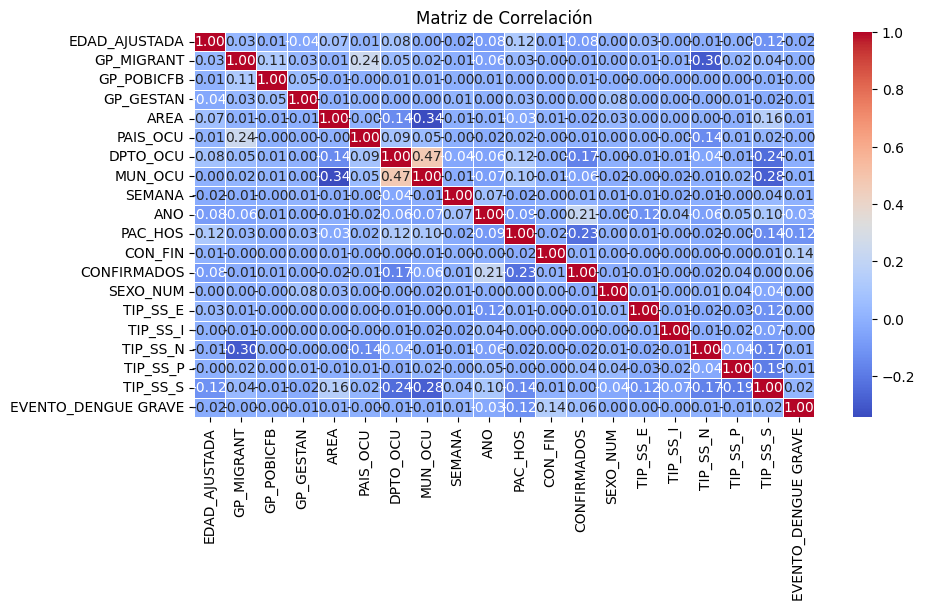

In [8]:
# Matriz de correlación con metodo Spearman
corr_matric = df.corr(method='spearman')

# Visualizar con un heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matric, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.7)
plt.title("Matriz de Correlación")
plt.show()

* Se verificó que las variables seleccionadas no presentan alta correlación entre sí, lo cual reduce el riesgo de redundancia informativa.

* La variable objetivo `CONFIRMADO` no mostró correlaciones lineales fuertes con ninguna otra variable individual.

* Como era esperable, `MUN_OCU` (municipio de ocurrencia) presentó una correlación elevada con `DPTO_OCU`(departamento de ocurrencia), lo cual es lógico dado su carácter jerárquico.

> Esta preparación adecuada del conjunto de datos garantiza que los modelos trabajen con variables informativas, sin sesgos de escala o ruido categórico innecesario, y permite evaluar de forma más justa el verdadero desempeño predictivo de cada enfoque.

## 3.3 Modelos evaluados

**Flujo de trabajo**\
División estratificada de datos: el 60% (340,901 registros) para entrenamiento y 40% (227,267 registros) para prueba, asegurando que ambas particiones mantuvieran la misma proporción de casos confirmados y no confirmados. 
Se fija una semilla aleatoria (`random_state=42`) para garantizar reproducibilidad.

**Modelos evaluados**\
1️⃣ K-Nearest Neighbors (KNN) \
2️⃣ Naive Bayes \
3️⃣ Logistic Regresion - L1(Lasso) - L2(Ridge)\
4️⃣ Decision Tree\
5️⃣ Random Forest\
6️⃣ XGBoost\
7️⃣ Support Vector Machine

Cada modelo fue configurado para adaptarse a la naturaleza de los datos y al objetivo principal del estudio: maximizar el recall para detectar la mayor cantidad de casos positivos posibles.

**Entrenamiento y evaluación**\
Para cada modelo se aplicó el siguiente flujo de entrenamiento:

1. Se construyó un pipeline personalizado, incluyendo según el caso:
    * Estandarización de variables.
    * Reducción de dimensionalidad.
    * Técnicas de balanceo de clases.

2. Se definió una rejilla de hiperparámetros (`param_grid`), y se ejecutó un proceso de validación cruzada (`GridSearchCV o RandomizedSearchCV`)para encontrar la combinación óptima de parámetros basada en la métrica de recall.

3. El modelo ajustado fue evaluado en el conjunto de prueba con las siguientes métricas:
    * Recall, Precisión, F1 Score.
    * Curvas ROC y Precision-Recall.
    * Matriz de confusión.
    * Tiempo de entrenamiento.

In [9]:
# División de conjuntos de datos

# Definir variable predictora y objetivo
X = df.drop(columns=['CONFIRMADOS'])
y = df['CONFIRMADOS'] 

# Division en train y test (60% train, 40% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Verificación de la división
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Test: {y_test.shape}")

Train: (568368, 19), Test: (378912, 19)
Train: (568368,), Test: (378912,)


In [10]:
# Búsqueda de mejores hiperparámetros
def buscar_param(grid, model_name, X_train, y_train):
    print(f"☑️ Entrenando {model_name}")

    start_time = time.time()
    grid.fit(X_train, y_train)
    fin_time = time.time() - start_time
    print(f"⏱️ Tiempo de fit: {fin_time/60:.2f} minutos")

    print(f"Mejores parámetros: {grid.best_params_}")
    best_model = grid.best_params_

    return best_model

In [11]:
# Entrenar y evaluar modelo
def train_and_evaluate(X_train, y_train, X_test, y_test, model, name=""):
    print(f"--- {name} ---")

    # Fit model
    start_time = time.time()
    model.fit(X_train, y_train)
    fin_time = time.time() - start_time
    print(f"Tiempo de fit: {fin_time/60:.2f} minutos")

    filename = f"{name}.pkl"
    joblib.dump(model, filename)
    print(f"Modelo guardado en: {filename}")

    # Train results
    print("---Train---")
    y_train_pred = model.predict(X_train)
    recall_train = recall_score(y_train, y_train_pred)
    print("Recall:  ", round(recall_train, 4))

    # Test results
    print("---Test---")
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None
    recall_test = recall_score(y_test, y_pred)
    print("Recall:  ", round(recall_test, 4))
    print("F1 Score:", round(f1_score(y_test, y_pred, average='weighted'),4))
    print("ROC AUC: ", round(roc_auc_score(y_test, y_proba),4))
    
    # Class report
    print("Classification report")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print()

    # Plots
    fpr, tpr, thresholds_auc  = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    # Mejor threshold según índice de Youden
    youden_index = tpr - fpr
    best_threshold_idx = np.argmax(youden_index)
    best_threshold = thresholds_auc[best_threshold_idx]

    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr[best_threshold_idx], tpr[best_threshold_idx], 'o', markersize=5,
             label=f"Best ({best_threshold:.2f})", c='red')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC Curve")
    plt.legend()

    # Curva Precision-Recall
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_idx]

    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.plot(recall[best_idx], precision[best_idx], 'o', markersize=10,
             label=f"Threshold ({best_threshold:.2f})", color='red')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

### 3.3.1 ☑️ K-Nearest Neighbors

In [12]:
# Tomar un subconjunto del entrenamiento para pruebas rápidas
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,  # Usa 10% del conjunto de entrenamiento
    stratify=y_train,
    random_state=42
)

# Balancear el subconjunto con SMOTE
smote = SMOTE(random_state=42)
X_train_sub_bal, y_train_sub_bal = smote.fit_resample(X_train_sub, y_train_sub)

In [13]:
# KNeighbors
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(
        algorithm='auto', 
        n_jobs=-1,
        weights='distance'))
])
param_grid_knn = {
    'clf__n_neighbors': [1, 3, 5],              # Vecinos principales
    'clf__metric': ['euclidean', 'manhattan']   # Métrica de distancia
}
grid_search_knn = RandomizedSearchCV(
    pipeline_knn, 
    param_distributions=param_grid_knn, 
    n_iter=5, 
    cv=3, scoring='recall', n_jobs=-1)

In [14]:
buscar_param(grid_search_knn, 
             "K-Nearest Neighbors",
             X_train_sub_bal, y_train_sub_bal)

☑️ Entrenando K-Nearest Neighbors


```
☑️ Entrenando K-Nearest Neighbors
⏱️ Tiempo de fit: 1.73 minutos
Mejores parámetros: {'clf__n_neighbors': 5, 'clf__metric': 'manhattan'}
```

In [9]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(
        n_neighbors = 5,
        metric = 'manhattan',
        algorithm='auto', 
        n_jobs=-1,
        weights='distance'))
])
pipeline_knn

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 KNeighborsClassifier(metric='manhattan', n_jobs=-1,
                                      weights='distance'))])

--- K-Nearest Neighbors ---
Tiempo de fit: 0.00 minutos
Modelo guardado en: K-Nearest Neighbors.pkl
---Train---
Recall:   0.9922
---Test---
Recall:   0.6947
F1 Score: 0.6642
ROC AUC:  0.7147
Classification report
              precision    recall  f1-score   support

           0       0.60      0.62      0.61    161486
           1       0.71      0.69      0.70    217426

    accuracy                           0.66    378912
   macro avg       0.66      0.66      0.66    378912
weighted avg       0.67      0.66      0.66    378912

TP: 151048, FP: 61096, TN: 100390, FN: 66378



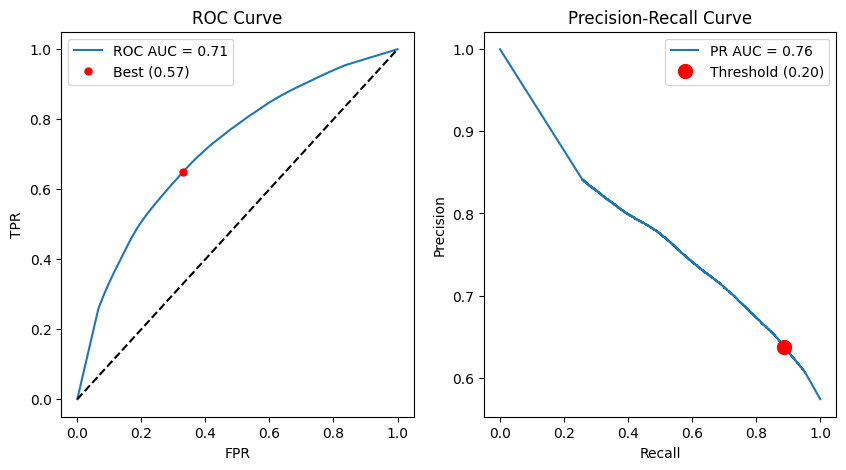

In [12]:
train_and_evaluate(X_train_sub_bal, y_train_sub_bal, 
                   X_test, y_test, 
                   pipeline_knn, name="K-Nearest Neighbors")

Para un subconjunto del 10% de los datos de entrenamiento con los mejores parámetros, el modelo _K-Nearest Neighbors_ mostró un tiempo de entrenamiento instantáneo. Sin embargo, presenta un **sobreajuste** marcado mientras alcanza un recall casi perfecto en entrenamiento  de 0.992, este cae al **0.695** en test, revelando poca capacidad de generalización. El modelo memoriza los datos de entrenamiento pero no generaliza adecuadamente en datos nuevos. Las métricas en el conjunto de test reflejan esta limitación: el F1-Score fue de 0.664 y ROC AUC 0.715, indicando una discriminación limitada entre clases. 

Analizando el comportamiento frente  a las clases, se observa un _desbalance hacia la clase positiva_ en el conjunto de prueba (217,426 frente a 161,486), tiene una mayor precisión (0.71) y F1-Score (0.70), lo que sugiere que el modelo está más adaptado a detectarla, pero sin cometer errores importantes. En términos absolutos, el modelo identificó **151,048 TP (69.5%)**, pero cometió **66,378 falsos negativos (30.5%)**, una tasa alta para las consideraciones de este trabajo. 

### 3.3.2 ☑️ Naive Bayes

In [4]:
# Naive Bayes (Gaussian)
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)), 
    ('smote', SMOTE(random_state=42)),
    ('clf', GaussianNB())
])
pipeline_nb

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('smote', SMOTE(random_state=42)), ('clf', GaussianNB())])

--- Naive Bayes ---
Tiempo de fit: 0.24 minutos
---Train---
Recall:   0.3858
---Test---
Recall:   0.3852
F1 Score: 0.5559
ROC AUC:  0.6537
Classification report
              precision    recall  f1-score   support

           0       0.50      0.82      0.62    161486
           1       0.74      0.39      0.51    217426

    accuracy                           0.57    378912
   macro avg       0.62      0.60      0.56    378912
weighted avg       0.64      0.57      0.56    378912

TP: 83746, FP: 28667, TN: 132819, FN: 133680



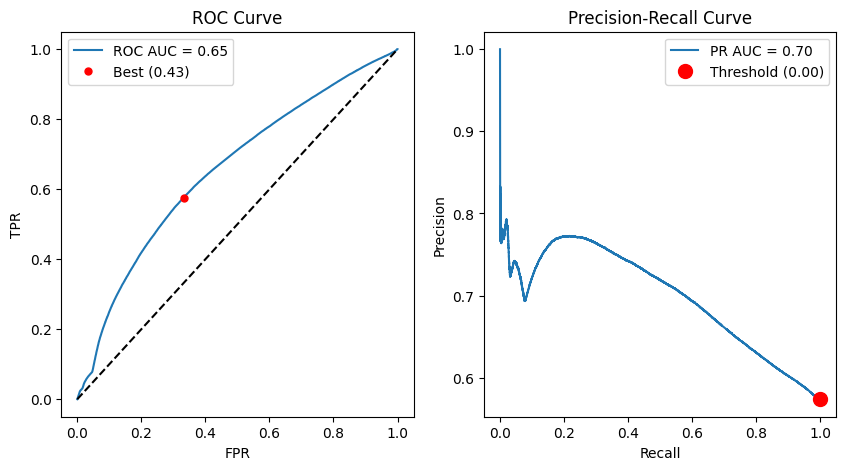

In [21]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_nb, name="Naive Bayes")

El modelo _GaussianNB_ presentó un tiempo de entrenamiento rápido (0.24 min), coherente con la naturaleza del algoritmo. En cuanto al rendimiento, presentó un desempeño subóptimo, tanto en entrenamiento como en prueba el recall fue similar **≈0.38**, lo que implica una falta de capacidad de ajuste y sugiere un problema de **underfitting**. Es decir, el modelo no logra capturar adecuadamente la complejidad de los datos. En el conjunto de prueba, el F1-Score alcanzó 0.5559 y el ROC-AUC fue de 0.6537, cifras que reflejan un rendimiento débil, confirmando su limitada capacidad de discriminación. 

Al observar el comportamiento entre las clases, se nota un sesgo importante hacia la clase 0, que tiene una baja precision (0.50) y alta sensibilidad (0.82), mientras que para la clase 1 el modelo presenta bajo recall (0.39) a pesar de una mayor precision (0.74), lo que implica en fallas en detectar instancias positivas. En los valores absolutos, el modelo solo logra detectar **8,346 TP (38.5%)**, mientras que comete **133,680 FN (61.4%)** del total de casos positivos, un valor altamente excesivo. En resumen, este modelo no discrimina eficazmente entre clases. 

### 3.3.3 ☑️ Logistic regression

In [ ]:
# Logistic regression L1
pipeline_rl1 = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        penalty="l1",
        solver="liblinear",
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])
param_grid_rl1 = {
    'clf__C': [0.005, 0.01, 0.1],
}
grid_search_rl1 = GridSearchCV(
    pipeline_rl1,
    param_grid_rl1,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [23]:
buscar_param(grid_search_rl1, 
             "Logistic Regresion L1",
             X_train, y_train)

☑️ Entrenando Logistic Regresion L1
Fitting 5 folds for each of 3 candidates, totalling 15 fits
⏱️ Tiempo de fit: 12.51 minutos
Mejores parámetros: {'clf__C': 0.1}


{'clf__C': 0.1}

In [25]:
pipeline_rl1 = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        C = 0.1,
        penalty="l1",
        solver="liblinear",
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])
pipeline_rl1

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

--- Logistic Regresion L1 ---
Tiempo de fit: 1.23 minutos
---Train---
Recall:   0.6431
---Test---
Recall:   0.6427
F1 Score: 0.6516
ROC AUC:  0.7015
Classification report
              precision    recall  f1-score   support

           0       0.58      0.66      0.62    161486
           1       0.72      0.64      0.68    217426

    accuracy                           0.65    378912
   macro avg       0.65      0.65      0.65    378912
weighted avg       0.66      0.65      0.65    378912

TP: 139747, FP: 55018, TN: 106468, FN: 77679



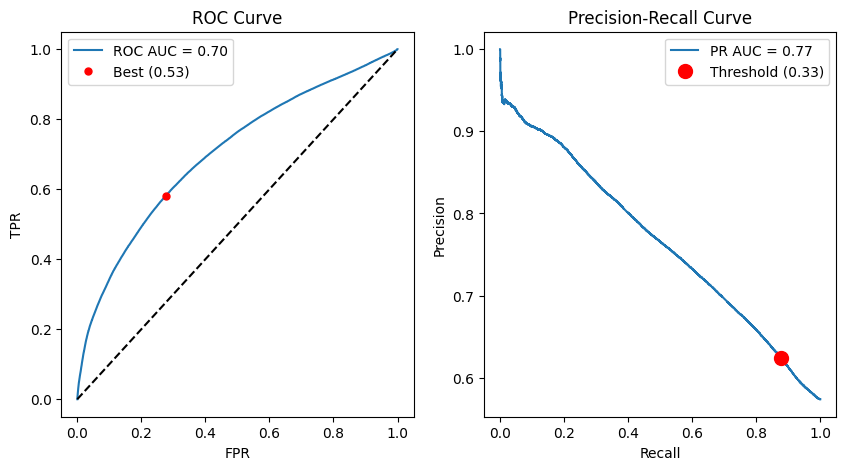

In [26]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_rl1, name="Logistic Regresion L1")

El modelo de _Regresión logística con regularización L1_ tuvo un tiempo de entrenamiento de 1.23 min, lo cual es razonable dada la naturaleza del modelo. El rendimiento fue estable entre los conjuntos de entrenamiento y prueba, con un recall **≈0.643**, lo que indica un nivel moderado de generalización. En cuanto al desempeño en el conjunto de prueba, se obtuvo un F1-Score de 0.0.6516 y un ROC-AUC de 0.7015, métricas que reflejan una capacidad de discriminación aceptable, sin ser sobresaliente. 

Observando la discriminación entre clases, el modelo mostro un sesgo leve hacia la clase positiva, con una mayor precisión (0.72) y F1-Score (0.78). Esto sugiere que la regresión logística penalizada logra detectar con mayor eficiencia la clase 1, con un margen de mejora en la clase negativa. 

En cifras absolutas, el modelo identificó **139,747 TP (64.3%)**, pero incurrió en **77,679 FN (35.7%)**, que sigue siendo significativos en el contexto de querer minimizarlos. En conjunto, el modelo ofrece una solución equilibrada y razonable, con buena estabilidad y discriminación en comparación con los anteriores. 

In [ ]:
# Logistic regression L2
pipeline_rl2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        penalty="l2",
        solver = "lbfgs",
        max_iter = 1000,
        random_state=42,
        class_weight='balanced'
    ))
])
param_grid_rl2 ={
    'clf__C': [0.01, 0.1, 0.5], 
}
grid_search_rl2 = GridSearchCV(
    pipeline_rl2,
    param_grid_rl2,
    scoring = 'recall',
    cv = 5,
    n_jobs = -1, 
    verbose=2
)

In [28]:
buscar_param(grid_search_rl2, 
             "Logistic Regresion L2",
             X_train, y_train)

☑️ Entrenando Logistic Regresion L2
Fitting 5 folds for each of 3 candidates, totalling 15 fits
⏱️ Tiempo de fit: 1.54 minutos
Mejores parámetros: {'clf__C': 0.01}


{'clf__C': 0.01}

In [29]:
pipeline_rl2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        C = 0.1,
        penalty="l2",
        solver = "lbfgs",
        max_iter = 1000,
        random_state=42,
        class_weight='balanced'
    ))
])
pipeline_rl2

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=10)),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, random_state=42))])

--- Logistic Regresion L2 ---
Tiempo de fit: 0.34 minutos
---Train---
Recall:   0.6188
---Test---
Recall:   0.6182
F1 Score: 0.627
ROC AUC:  0.6658
Classification report
              precision    recall  f1-score   support

           0       0.55      0.63      0.59    161486
           1       0.69      0.62      0.65    217426

    accuracy                           0.63    378912
   macro avg       0.62      0.63      0.62    378912
weighted avg       0.63      0.63      0.63    378912

TP: 134423, FP: 59077, TN: 102409, FN: 83003



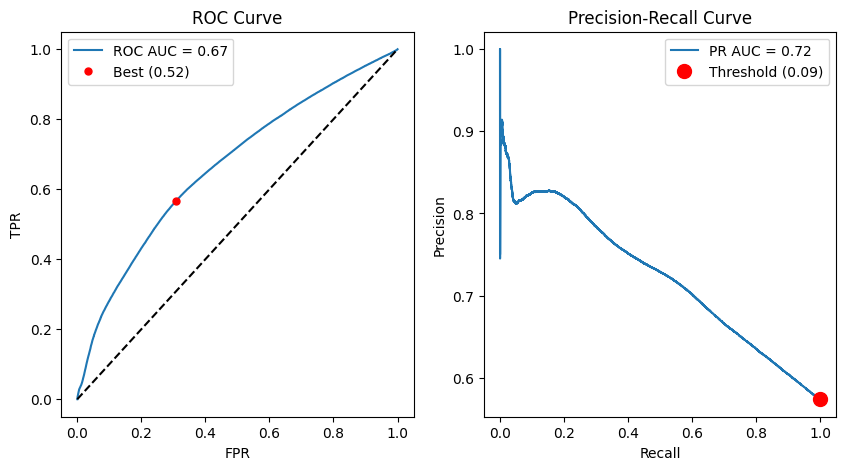

In [30]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_rl2, name="Logistic Regresion L2")

El modelo de _Regresión logística con penalización L2_ mostró un rendimiento consistente pero limitado completando el entrenamiento en solo 0.34 minutos, coherente con su eficiencia computacional. Su desempeño fue consistente entre los conjuntos de entrenamiento y prueba, con un recall **≈0.618**. A nivel de métricas en el conjunto de prueba, el modelo tuvo un rendimiento moderado ligeramente inferior al alcanzado con la penalización L2, con un F1-Score de 0.627 y un ROC AUC de 0.665.

Al examinar la capacidad discriminativa entre clases, se observa que nuevamente la clase 1 es la mayoritaria, favorecida con mayor precision (0.69) y un F1-score de 0.65, mientras que la clase 0 tiene una precision de 0.55 y F1-Score de 0.59. Esto sugiere que el modelo logra identificar razonablemente los casos positivos, aunque a costa de una menor precision en la clase negativa.

En términos absolutos, se identificaron **134,423 TP (61.8%)**, mientras que se presentaron **83,003 FN (38.2%)**, 2.5% más que en la penalización L1, un número considerable de casos positivos que no están siendo reconocidos correctamente. En conjunto, la regresión logística con L2 ofrece un rendimiento estable, con buen balance entre sensibilidad y precisión, aunque no logra superar el desempeño del modelo con regularización L1. 

### 3.3.4 ☑️ Decision Tree

In [32]:
# Decision Tree
pipeline_dt = Pipeline([     
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced' 
    ))
])
param_grid_dt ={
    'clf__max_depth': [5, 10],                  # Profundidad máxima
    'clf__min_samples_split': [2, 5, 10],       # Muestras para dividir nodo
    'clf__min_samples_leaf': [2, 4],            # Muestras en una hoja
    'clf__criterion': ['gini', 'entropy']       # Calidad de división
}
grid_search_dt = RandomizedSearchCV(
    pipeline_dt,
    param_grid_dt,
    n_iter=10,
    scoring='recall',  
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [33]:
buscar_param(grid_search_dt, 
             "Decision Tree",
             X_train, y_train)

☑️ Entrenando Decision Tree
Fitting 3 folds for each of 10 candidates, totalling 30 fits
⏱️ Tiempo de fit: 13.78 minutos
Mejores parámetros: {'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_depth': 10, 'clf__criterion': 'gini'}


{'clf__min_samples_split': 10,
 'clf__min_samples_leaf': 4,
 'clf__max_depth': 10,
 'clf__criterion': 'gini'}

In [34]:
pipeline_dt = Pipeline([     
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(
        min_samples_split = 10,
        min_samples_leaf = 4,
        max_depth = 10,
        criterion = 'gini',
        random_state=42,
        class_weight='balanced' 
    ))
])
pipeline_dt

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_leaf=4,
                                        min_samples_split=10,
                                        random_state=42))])

--- Decision Tree ---
Tiempo de fit: 1.76 minutos
---Train---
Recall:   0.6933
---Test---
Recall:   0.6921
F1 Score: 0.7159
ROC AUC:  0.7898
Classification report
              precision    recall  f1-score   support

           0       0.64      0.74      0.69    161486
           1       0.78      0.69      0.74    217426

    accuracy                           0.71    378912
   macro avg       0.71      0.72      0.71    378912
weighted avg       0.72      0.71      0.72    378912

TP: 150473, FP: 41299, TN: 120187, FN: 66953



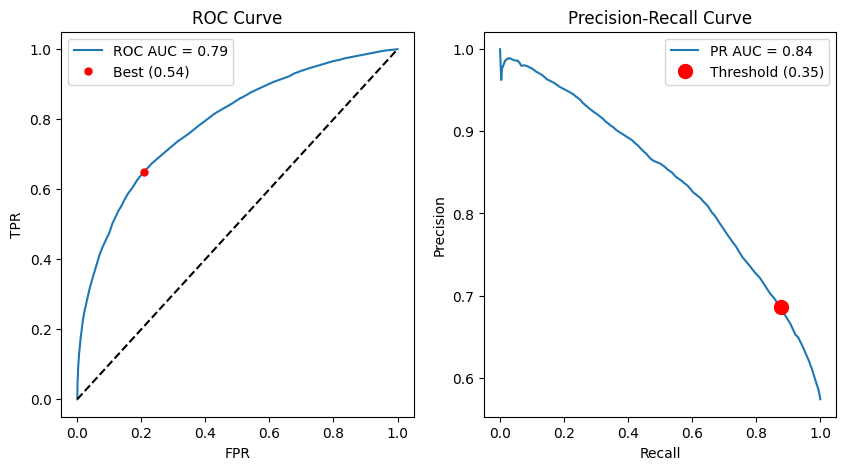

In [35]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_dt, name="Decision Tree")

El modelo _Decision Tree_ demostró un rendimiento equilibrado con un tiempo de entrenamiento razonable de 1.76 min. El rendimiento fue estable, con un recall de **≈0.693** entre entrenamiento y prueba, lo que indica que el problema no tiene problemas evidentes de sobreajuste o subajuste, logra capturar patrones relevantes sin perder capacidad de generalización. En el conjunto de prueba, las métricas muestran un rendimiento fuerte, el F1-Score alcanzó 0.7159 y el ROC AUC fue de 0.7898, la más alta entre los modelos evaluados hasta ahora, lo que evidencia su capacidad sustancial para discriminar entre clases. 

Observando la distribución por clase, el modelo maneja bastante bien el balance: para la clase 1, que es la mayoritaria, logra una precisión de 0.78 y un F1 de 0.74, mientras que en la clase 0 obtiene una precisión de 0.64 y un F1 de 0.69. Esto indica que el árbol logra distinguir ambas clases con un buen nivel de detalle, con un sesgo hacia la clase positiva. 

En cuanto a los resultados absolutos, se identificaron **150,473 TP (69.2%)** y **66,953 FN (30.3%)**, una mejora significativa respecto a los otros modelos. En resumen, el árbol de decisión ofrece un equilibrio muy sólido entre precisión y sensibilidad, con un excelente poder de discriminación entre clases, siendo uno de los modelos más cercanos al objetivo de estudio. 

### 3.3.5 ☑️ Random Forest

In [18]:
# Random Forest
pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])
param_dist = {
    'clf__n_estimators': [100, 200, 300],   # Arboles en el bosque
    'clf__max_depth': [5, 10, 20],       # Profundidad máxima
    'clf__min_samples_split': [2, 5, 10],   # Número minimo de muestras
}
grid_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2,
)

In [19]:
buscar_param(grid_search_rf, 
             "Random Forest",
             X_train, y_train)

☑️ Entrenando Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
⏱️ Tiempo de fit: 10.46 minutos
Mejores parámetros: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__max_depth': 20}


{'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__max_depth': 20}

In [20]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 100, 
        min_samples_split = 5, 
        max_depth = 20,
        random_state=42,
        class_weight='balanced'
    ))
])
pipeline_rf

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=5,
                                        random_state=42))])

--- Random Forest ---
Tiempo de fit: 3.44 minutos
---Train---
Recall:   0.8033
---Test---
Recall:   0.751
F1 Score: 0.753
ROC AUC:  0.8325
Classification report
              precision    recall  f1-score   support

           0       0.69      0.75      0.72    161486
           1       0.80      0.75      0.78    217426

    accuracy                           0.75    378912
   macro avg       0.75      0.75      0.75    378912
weighted avg       0.76      0.75      0.75    378912

TP: 163278, FP: 39834, TN: 121652, FN: 54148



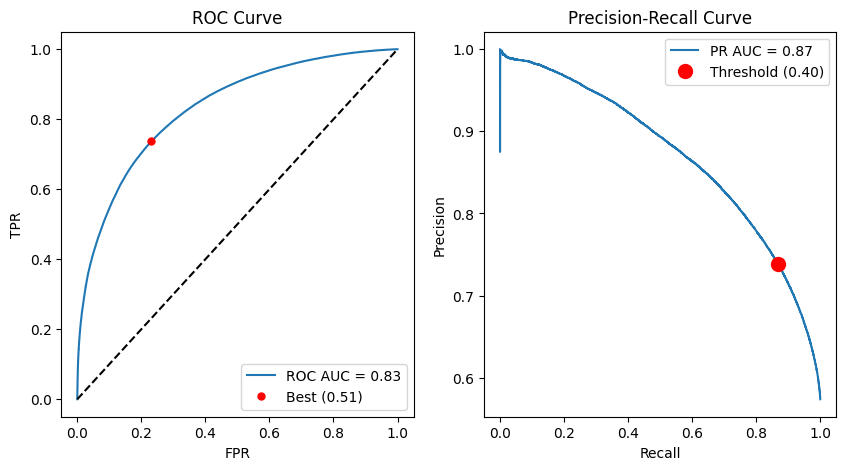

In [21]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_rf, name="Random Forest")

El modelo de _Random Forest_ presentó un alto rendimiento predictivo, con un tiempo de entrenamiento de 3.44 minutos, un valor esperado considerando el ensamblado de múltiples árboles. A pesar de su complejidad, el tiempo sigue siendo razonable para el tamaño del conjunto de datos utilizado. El desempeño fue robusto tanto en entrenamiento como en prueba con un recall de 0.8033 y **0.751**, respectivamente. Esta leve caída se debe al aprendizaje del modelo, sugiriendo que el modelo generaliza bien, sin evidencias claras de overfitting. El conjunto de prueba alcanzó un F1 score de 0.753 y un ROC AUC de 0.8325, lo cual refleja una excelente capacidad de discriminación entre clases. 

En cuanto a las métricas específicas por clase, el modelo mantiene un buen equilibrio: para la clase 1, que es la mayoritaria, se obtiene una precisión de 0.80 y un F1 de 0.78, mientras que en la clase 0 se logra una precisión de 0.69 y un F1 de 0.72. Esto muestra que, a diferencia de modelos más simples, el Random Forest logra capturar correctamente patrones de ambas clases, con un sesgo relativamente controlado hacia la clase positiva.

En cifras absolutas, el modelo identifica **163,178 FP (75%)** y reduce la cantidad de falsos negativos a **54,148 (25%)**, un desempeño muy favorable considerado que el objetivo es minimizar los errores. En conjunto, Random Forest se consolida como uno de los modelos más eficaces en cuanto a precisión, equilibrio entre clases y capacidad predictiva.

### 3.3.6 ☑️ XGBoost

In [22]:
#XGBoost
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
    ))
])

param_grid_xgb = {
    'clf__n_estimators': [100, 200],        # Arboles
    'clf__max_depth': [3, 6],               # Produndidad máxima
    'clf__learning_rate': [0.01, 0.1],      # Aprendizaje
    'clf__subsample': [0.8, 1.0],           # datos usados en cada árbol
    'clf__colsample_bytree': [0.8, 1.0],    # features se usan por árbol
    'clf__gamma': [0, 1, 5],                # regularización: mínima ganancia para dividir un nodo
}
grid_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    n_iter=10,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [23]:
buscar_param(grid_search_xgb, 
             "XGBoost",
             X_train, y_train)

☑️ Entrenando XGBoost
Fitting 3 folds for each of 10 candidates, totalling 30 fits
⏱️ Tiempo de fit: 16.82 minutos
Mejores parámetros: {'clf__subsample': 0.8, 'clf__n_estimators': 200, 'clf__max_depth': 6, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 1.0}


{'clf__subsample': 0.8,
 'clf__n_estimators': 200,
 'clf__max_depth': 6,
 'clf__learning_rate': 0.1,
 'clf__gamma': 0,
 'clf__colsample_bytree': 1.0}

In [24]:
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        subsample=0.8,
        n_estimators = 200,
        max_depth = 6,
        learning_rate = 0.1,
        gamma = 0,
        colsample_bytree = 1.0,
        random_state=42,
        n_jobs=-1,
    ))
])
pipeline_xgb

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

--- XGBoost ---
Tiempo de fit: 1.41 minutos
---Train---
Recall:   0.7597
---Test---
Recall:   0.7583
F1 Score: 0.75
ROC AUC:  0.8307
Classification report
              precision    recall  f1-score   support

           0       0.69      0.74      0.71    161486
           1       0.80      0.76      0.78    217426

    accuracy                           0.75    378912
   macro avg       0.74      0.75      0.75    378912
weighted avg       0.75      0.75      0.75    378912

TP: 164877, FP: 42477, TN: 119009, FN: 52549



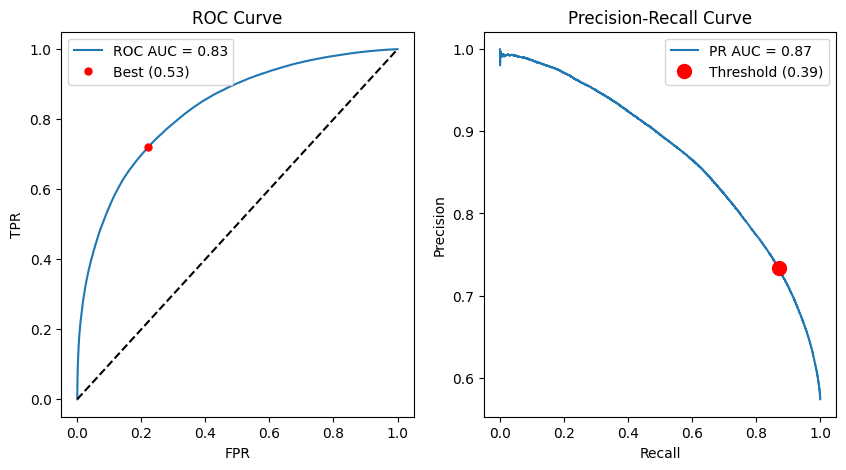

In [25]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_xgb, name="XGBoost")

El modelo _XGBoost_ completó su entrenamiento en 1.41 minutos, lo cual es eficiente dada su estructura basada en boosting secuencial. En términos de rendimiento el modelo mostró gran consistencia entre los conjuntos de entrenamiento y prueba, con un recall **≈0.759** lo que subraya su capacidad de generalizar correctamente. Las métricas de evaluación en test fueron sólidas con un F1 score de 0.75 y un ROC AUC de 0.8307, lo que demuestra una alta discriminación entre clases. 

En cuanto al balance de clases, el modelo mantiene un buen desempeño: para la clase mayoritaria (1), alcanza una precisión de 0.80 y un F1 score de 0.78, mientras que para la clase 0 obtiene una precisión de 0.69 y un F1 de 0.71. Este equilibrio muestra que XGBoost no sacrifica la clase minoritaria en favor de la dominante y logra un control aceptable del sesgo.

Finalmente, desde el punto de vista operativo, el modelo logró **164,877 TP (75.8%)** y **52,549 FN (24.2%)**, el menor número de FN registrado entre los modelos evaluados hasta ahora. En conjunto, XGBoost ofrece una combinación óptima de velocidad, precisión, robustez y capacidad discriminativa, consolidándose como una de las opciones más recomendables para la tarea abordada.

### 3.3.7. ☑️ Support Vector Machine

In [26]:
#SVM 
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
     ('pca', PCA()),
    ('smote', SMOTE(random_state=42)),
    ('clf', SGDClassifier(
        loss='hinge',
        max_iter=1000,
        tol=1e-3,
        random_state=42
    ))
])
param_grid_svm = {
    'clf__alpha': [0.0001, 0.001],              # regularización inversa
    'clf__penalty': ['l2'],                     # tipo de penalización
    'clf__loss': ['hinge', 'modified_huber']    # perdida
}
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)


In [27]:
buscar_param(grid_search_svm, 
             "SVM",
             X_train, y_train)

☑️ Entrenando SVM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
⏱️ Tiempo de fit: 17.10 minutos
Mejores parámetros: {'clf__alpha': 0.001, 'clf__loss': 'modified_huber', 'clf__penalty': 'l2'}


{'clf__alpha': 0.001, 'clf__loss': 'modified_huber', 'clf__penalty': 'l2'}

In [29]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
     ('pca', PCA()),
    ('smote', SMOTE(random_state=42)),
    ('clf', SGDClassifier(
        alpha = 0.001, 
        loss = 'modified_huber', 
        penalty = 'l2',
        max_iter=1000,
        tol=1e-3,
        random_state=42
    ))
])
pipeline_svm

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 SGDClassifier(alpha=0.001, loss='modified_huber',
                               random_state=42))])

--- SVM ---
Tiempo de fit: 1.06 minutos
---Train---
Recall:   0.6404
---Test---
Recall:   0.6401
F1 Score: 0.6504
ROC AUC:  0.6999
Classification report
              precision    recall  f1-score   support

           0       0.58      0.66      0.62    161486
           1       0.72      0.64      0.68    217426

    accuracy                           0.65    378912
   macro avg       0.65      0.65      0.65    378912
weighted avg       0.66      0.65      0.65    378912

TP: 139168, FP: 54904, TN: 106582, FN: 78258



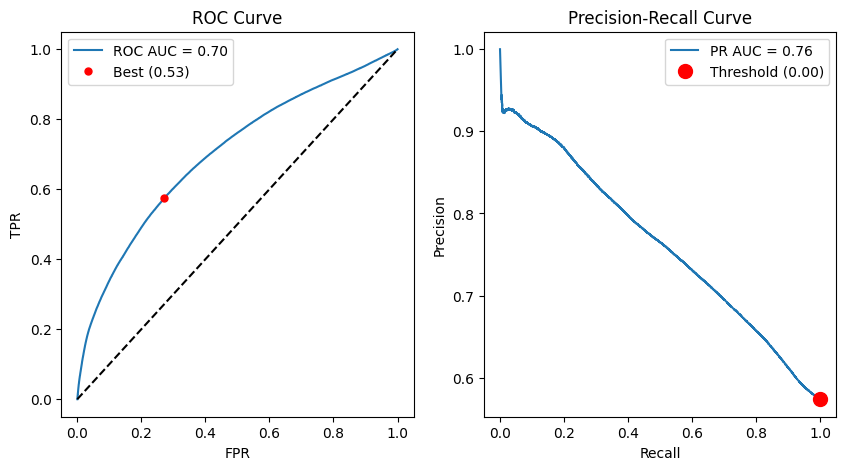

In [30]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_svm, name="SVM")

El modelo _SVM_ (Máquinas de Vectores de Soporte) presentó un tiempo de entrenamiento de 1.06 minutos. En términos de generalización, el modelo mostró una coincidencia casi exacta entre el recall de entrenamiento y de prueba **≈0.64**, lo cual indica que la capacidad de generalizar a nuevos datos es bastante estable. Respecto a las métricas obtenidas en test, se evidencia un desempeño moderado: un F1 score de 0.6504 y un ROC AUC de 0.6999, lo que posiciona al modelo en un rendimiento medio en comparación con el resto de los algoritmos evaluados.

La capacidad del modelo para discriminar entre clases se refleja en una ligera superioridad en la predicción de la clase 1 (mayoritaria), donde se obtuvo una precisión de 0.72 y un f1-score de 0.68, frente a un f1-score de 0.62 en la clase 0. Aunque el modelo tiende levemente hacia la clase mayoritaria, no presenta un sesgo extremo.

En términos operativos, se registraron **139,168 TP (64%)** y **78,258 FN (36%)**, un número relativamente alto, en comparación a lo obtenido con los árboles. En resumen, SVM ofrece una solución aceptable con buen equilibrio entre clases y tiempos razonables de ejecución.

## 3.4 Optimización de modelos

### 3.4.1 Logistic Regresion

Evaluación de LogisticRegression con solver `SAGA` y búsqueda de mejores hiperparámetros.

In [20]:
pipeline_logreg= Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        solver="saga",  # Cambiado
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    ))
])
param_grid_logreg = {
    'clf__penalty': ['l1', 'l2'],               # Comparar ambas penalizaciones
    'clf__C': [0.01, 0.1, 0.5]          # Regularización inversa
}
grid_logreg = GridSearchCV(
    pipeline_logreg,
    param_grid_logreg,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [21]:
buscar_param(grid_logreg, 
             "Regresion Logistica",
             X_train, y_train)

☑️ Entrenando Regresion Logistica
Fitting 5 folds for each of 6 candidates, totalling 30 fits
⏱️ Tiempo de fit: 21.68 minutos
Mejores parámetros: {'clf__C': 0.1, 'clf__penalty': 'l1'}


{'clf__C': 0.1, 'clf__penalty': 'l1'}

In [22]:
pipeline_logreg= Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        solver="saga",  # Cambiado
        max_iter=1000,
        penalty = 'l1',
        C = 0.1,
        random_state=42,
        class_weight='balanced'
    ))
])
pipeline_logreg

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='saga'))])

--- Logistic Regresio ---
Tiempo de fit: 0.90 minutos
---Train---
Recall:   0.6432
---Test---
Recall:   0.6428
F1 Score: 0.6517
ROC AUC:  0.7015
Classification report
              precision    recall  f1-score   support

           0       0.58      0.66      0.62    161486
           1       0.72      0.64      0.68    217426

    accuracy                           0.65    378912
   macro avg       0.65      0.65      0.65    378912
weighted avg       0.66      0.65      0.65    378912

TP: 139762, FP: 55017, TN: 106469, FN: 77664



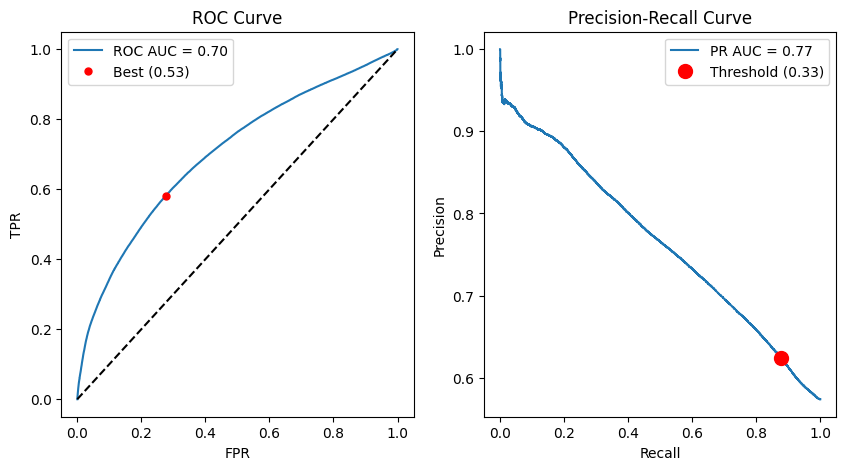

In [ ]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_logreg, name="Logistic Regresion")

Para regresión logística con penalización L1, el solver `saga` evidenció una mejora en el tiempo de entrenamiento, sin mejoras notables en las métricas evaluadas.

### 3.4.2 XGBoost

Evaluación con el método `hist` y búsqueda de mejores hiperparámetros

In [24]:
# XGBoost con mejores parametros
pipeline_xgb_op = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        tree_method='hist'  # Usar el método de árbol 'hist'
    ))
])

param_grid_xgb_op= {
    'clf__n_estimators': [100, 200],        # Arboles
    'clf__max_depth': [3, 6],               # Produndidad máxima
    'clf__learning_rate': [0.01, 0.1],      # Aprendizaje
    'clf__subsample': [0.8, 1.0],           # datos usados en cada árbol
    'clf__colsample_bytree': [0.8, 1.0],    # features se usan por árbol
    'clf__gamma': [0, 1, 5],                # regularización: mínima ganancia para dividir un nodo
}
grid_search_xgb_op = RandomizedSearchCV(
    pipeline_xgb_op,
    param_grid_xgb_op,
    n_iter=10,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [25]:
buscar_param(grid_search_xgb_op, 
             "XGBoost op",
             X_train, y_train)

☑️ Entrenando XGBoost op
Fitting 3 folds for each of 10 candidates, totalling 30 fits
⏱️ Tiempo de fit: 15.23 minutos
Mejores parámetros: {'clf__subsample': 1.0, 'clf__n_estimators': 200, 'clf__max_depth': 6, 'clf__learning_rate': 0.1, 'clf__gamma': 1, 'clf__colsample_bytree': 0.8}


{'clf__subsample': 1.0,
 'clf__n_estimators': 200,
 'clf__max_depth': 6,
 'clf__learning_rate': 0.1,
 'clf__gamma': 1,
 'clf__colsample_bytree': 0.8}

In [26]:
pipeline_xgb_op = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(
        objective='binary:logistic',
        subsample = 1.0,
        n_estimators = 200,
        max_depth = 6,
        learning_rate = 0.1,
        gamma = 1,
        colsample_bytree = 0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1,
        tree_method='hist'  # Usar el método de árbol 'hist'
    ))
])
pipeline_xgb_op

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

--- XGBoost optimizado ---
Tiempo de fit: 0.88 minutos
---Train---
Recall:   0.7582
---Test---
Recall:   0.7564
F1 Score: 0.7485
ROC AUC:  0.8286
Classification report
              precision    recall  f1-score   support

           0       0.69      0.74      0.71    161486
           1       0.79      0.76      0.77    217426

    accuracy                           0.75    378912
   macro avg       0.74      0.75      0.74    378912
weighted avg       0.75      0.75      0.75    378912

TP: 164460, FP: 42631, TN: 118855, FN: 52966



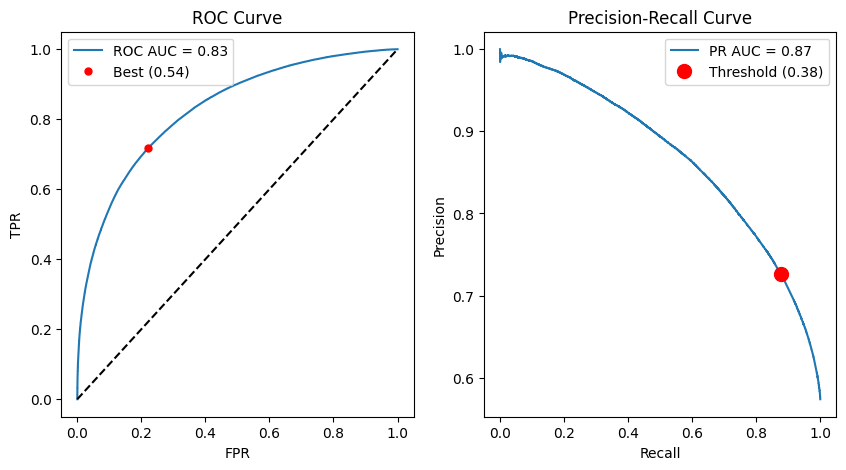

In [27]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_xgb_op, name="XGBoost optimizado")

In [29]:
def explicar_prediccion_lime(pipe, X_train, X_test, instance_index, class_names, num_features=10):

    # Obtener el modelo final del pipeline
    model = pipe.named_steps['clf']
    
    # Crear el explicador LIME para datos tabulares
    explainer = LimeTabularExplainer(
        training_data=X_train.values,  # Datos de entrenamiento
        mode="classification",         # Tipo de modelo (clasificación)
        feature_names=X_train.columns, # Nombres de las características
        class_names=class_names,      # Nombres de las clases
        discretize_continuous=True     # Si se desea discretizar variables continuas
    )
    
    # Obtener la instancia a explicar
    instance = X_test.iloc[instance_index].values.reshape(1, -1)

    # Explicar la predicción del modelo para la instancia
    explanation = explainer.explain_instance(instance[0], model.predict_proba, num_features=num_features)
    
    # Mostrar la explicación
    explanation.show_in_notebook()
    
    return explanation



In [30]:
class_names = ['No Confirmado', 'Confirmado']
explanation = explicar_prediccion_lime(pipeline_xgb_op, X_train, X_test, instance_index=5, class_names=class_names, num_features=10)

El tiempo de entrenamiento con el tree method `hist` se redujo considerablemente, aunque el rendimiento general obtenido disminuyó un poco. 

### 3.4.3 Linear Support Vector Classifier

Integración de otros modelos basados es márgenes

In [31]:
pipeline_svm_lsvc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(
        penalty='l2',
        max_iter=5000,
        dual=False,               # importante para conjuntos no muy grandes
        random_state=42,
        class_weight='balanced'  # buena práctica para desbalance
    ))
])

param_grid_lsvc = {
    'clf__C': [0.01, 0.1, 1],      # inverso de la regularización
}

grid_search_lsvc = GridSearchCV(
    pipeline_svm_lsvc,
    param_grid_lsvc,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [32]:
buscar_param(grid_search_lsvc, 
             "LinearSVC",
             X_train, y_train)

☑️ Entrenando LinearSVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
⏱️ Tiempo de fit: 10.92 minutos
Mejores parámetros: {'clf__C': 0.01}


{'clf__C': 0.01}

In [33]:
pipeline_svm_lsvc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(
        C = 0.01,
        penalty='l2',
        max_iter=5000,
        dual=False,               # importante para conjuntos no muy grandes
        random_state=42,
        class_weight='balanced'  # buena práctica para desbalance
    ))
])
pipeline_svm_lsvc

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 LinearSVC(C=0.01, class_weight='balanced', dual=False,
                           max_iter=5000, random_state=42))])

--- LinearSVC ---
Tiempo de fit: 1.12 minutos
---Train---
Recall:   0.6413
---Test---
Recall:   0.6409
F1 Score: 0.6515
ROC AUC:  0.7013
Classification report
              precision    recall  f1-score   support

           0       0.58      0.66      0.62    161486
           1       0.72      0.64      0.68    217426

    accuracy                           0.65    378912
   macro avg       0.65      0.65      0.65    378912
weighted avg       0.66      0.65      0.65    378912

TP: 139359, FP: 54693, TN: 106793, FN: 78067



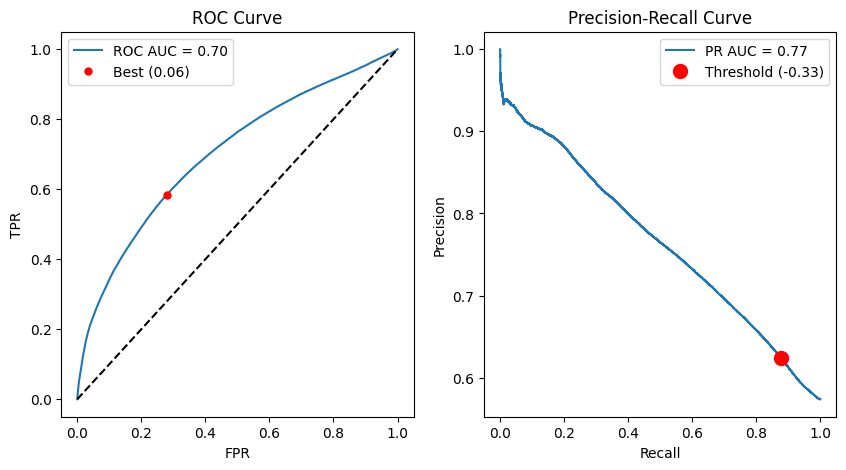

In [34]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_svm_lsvc, name="LinearSVC")

El modelo _LinearSVC_ presentó un tiempo de entrenamiento de 1.12 minutos, lo cual resulta eficiente considerando el tamaño del conjunto de datos y la naturaleza lineal del clasificador. Mostró una notable estabilidad entre el rendimiento en entrenamiento y prueba, con un recall prácticamente idéntico (0.6413 vs. 0.6409), lo que indica buena capacidad de generalización sin señales de overfitting. El F1 Score obtenido en test fue de 0.6515, acompañado de un ROC AUC de 0.7013, posicionando su rendimiento en un nivel medio-alto entre los modelos evaluados. 

En cuanto al equilibrio entre clases, mantuvo una tendencia similar al modelo SVM tradicional, mostrando mejor desempeño en la clase 1 (mayoritaria), con una precisión de 0.72 y un f1-score de 0.68, frente a un f1-score de 0.62 en la clase 0. Aunque aún se percibe una ligera inclinación hacia la clase positiva, el modelo mantiene una clasificación razonablemente equilibrada. Se registraron **139,359 TP (64%)** y **78,067 FN (36%)**, cifras similares a las del SVM, lo que sugiere que ambos modelos tienen comportamientos muy cercanos, aunque LinearSVC destaca por una ligera mejora en estabilidad y AUC. En resumen, LinearSVC es una opción sólida y eficiente con buen balance entre velocidad, generalización y rendimiento.


### 3.4.4 Radial Basis Function Kernel

In [36]:
pipeline_svm_sbf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('smote', SMOTE(random_state=42)),
    ('rbf', RBFSampler(gamma=0.1, random_state=42, n_components=500)),  # Aquí agregamos el nombre
    ('svm', SGDClassifier(  # También agregamos un nombre para el clasificador
        loss='hinge',
        max_iter=1000,
        tol=1e-3,
        random_state=42,
        class_weight='balanced',
        alpha=0.0001, 
    ))
])

--- RBF Sampler ---
Tiempo de fit: 1.24 minutos
---Train---
Recall:   0.6519
---Test---
Recall:   0.6506
F1 Score: 0.6588
ROC AUC:  0.7161
Classification report
              precision    recall  f1-score   support

           0       0.59      0.67      0.62    161486
           1       0.72      0.65      0.69    217426

    accuracy                           0.66    378912
   macro avg       0.65      0.66      0.65    378912
weighted avg       0.67      0.66      0.66    378912

TP: 141448, FP: 53977, TN: 107509, FN: 75978



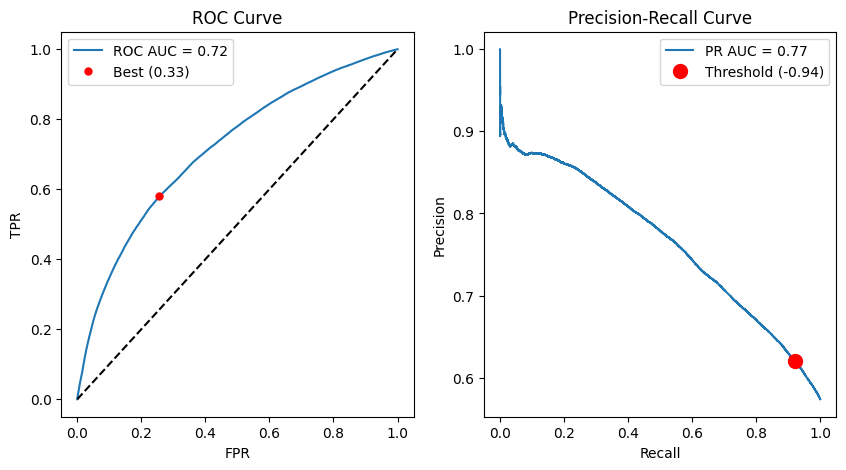

In [37]:
train_and_evaluate(X_train, y_train, 
                   X_test, y_test, 
                   pipeline_svm_sbf, name="RBF Sampler")

El modelo _RBF Sampler_, con un tiempo de entrenamiento de 1.24 minutos, logra un desempeño competitivo al aproximar un kernel RBF mediante proyecciones explícitas, combinando la eficiencia de modelos lineales con la capacidad de captura de no linealidades. Su recall en entrenamiento (0.6519) y prueba (0.6506) es alto y muy consistente, lo que indica buena generalización. El F1 Score alcanza 0.6588 y el ROC AUC 0.7161, superando a modelos lineales como Logistic Regression y SVM en capacidad discriminativa. 

El modelo muestra un balance aceptable entre precisión (0.72) y recall (0.65) para la clase 1 (positiva), con un f1-score de 0.69, mientras que para la clase 0 alcanza un f1-score de 0.62, indicando una ligera preferencia hacia la clase mayoritaria pero con mejoras respecto a otros modelos lineales. Se registraron **141,448 TP (65%)** y **75,978 FN (35%)**, mejorando levemente el poder de detección de casos positivos frente a modelos como LinearSVC y SVM tradicional. En conjunto, el RBF Sampler ofrece una opción robusta cuando se busca un equilibrio entre velocidad, capacidad de generalización y aprovechamiento de patrones no lineales sin recurrir a métodos más complejos o costosos computacionalmente.


> Se aplicaron optimizaciones a modelos como `ball_tree` para KNN, `partialfit`para entrenar GaussianNB, que aunque redujeron el tiempo de entrenamiento para la mayoría de casos, no mejoraron las métricas de evaluación. 

## 3.5 Conclusión

In [10]:
model_paths = [
    r"C:\Users\Hp\MACHINE\pkls\KNearest_Neighbors.pkl",
    r"C:\Users\Hp\MACHINE\pkls\Bayes.pkl",
    r"C:\Users\Hp\MACHINE\pkls\Logistic_RegresionL1.pkl",
    r"C:\Users\Hp\MACHINE\pkls\Logistic_RegresionL2.pkl",
    r"C:\Users\Hp\MACHINE\pkls\Decision_Tree.pkl",
    r"C:\Users\Hp\MACHINE\pkls\Random_Forest.pkl",
    r"C:\Users\Hp\MACHINE\pkls\XGBoost.pkl",
    r"C:\Users\Hp\MACHINE\pkls\SVM.pkl",
]                       

model_labels = [
    "KNN",
    "Bayes",
    "Log Reg L1",
    "Log Reg L2",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "SVM"
]                 

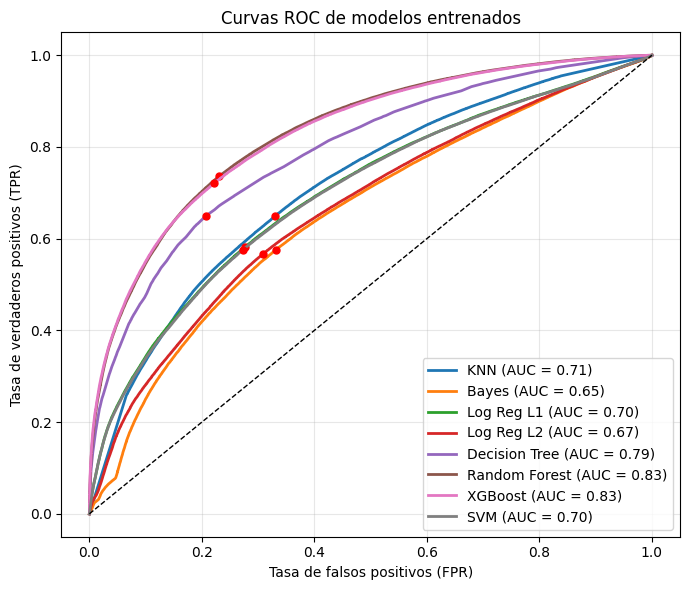

In [11]:
# ------------------------------------------------------------------
# 3. Curva ROC para cada modelo ------------------------------------
# ------------------------------------------------------------------
plt.figure(figsize=(7, 6))

for path, label in zip(model_paths, model_labels):
    # ---------- leer el modelo ----------
    model = joblib.load(path)        # o pickle.load(open(path, "rb"))

    # ---------- puntuaciones ----------
    #   • clasificadores probabilísticos → predict_proba()[:, 1]
    #   • SVM lineal/SVM rbf → decision_function()
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    # ---------- ROC ----------
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # ---------- mejor umbral (Youden J = TPR-FPR) ----------
    best_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[best_idx]

    # ---------- dibujo ----------
    plt.plot(
        fpr,
        tpr,
        label=f"{label} (AUC = {roc_auc:.2f})",
        lw=2,
    )
    # punto óptimo
    plt.plot(
        fpr[best_idx],
        tpr[best_idx],
        marker="o",
        markersize=5,
        color="red",
    )

# diagonal aleatoria
plt.plot([0, 1], [0, 1], "k--", lw=1)

# ------------------------------------------------------------------
# 4. Formato de la figura ------------------------------------------
# ------------------------------------------------------------------
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curvas ROC de modelos entrenados")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

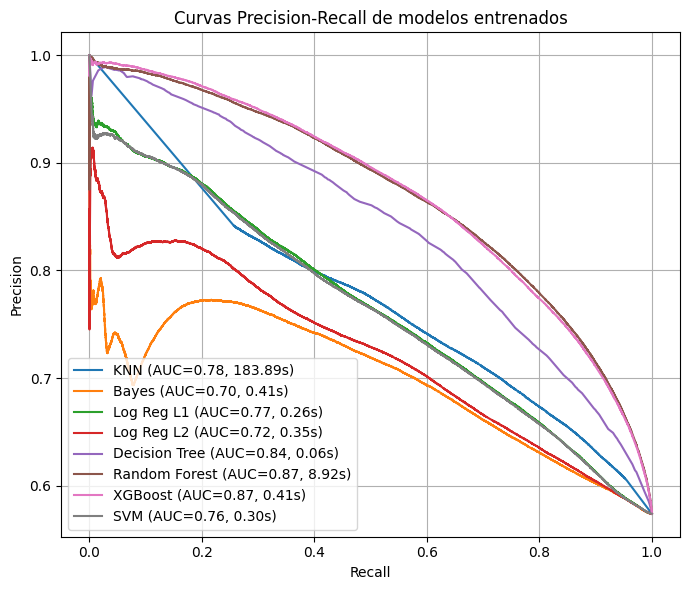

In [12]:
plt.figure(figsize=(7, 6))

for path, label in zip(model_paths, model_labels):
    model = joblib.load(path)

    # Tiempo de predicción
    start = time.time()
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:  # SVM sin probas
        y_scores = model.decision_function(X_test)
    elapsed = time.time() - start

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f"{label} (AUC={pr_auc:.2f}, {elapsed:.2f}s)")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall de modelos entrenados")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tras comparar diversos algoritmos de clasificación, se observa que los modelos de árboles, en particular **Random Forest** y **XGBoost**, presentan el mejor desempeño general. Ambos superan consistentemente al resto en métricas clave como *recall*, *F1 score* y *ROC AUC*, logrando capturar patrones complejos del conjunto de datos con alta capacidad predictiva. 

En especial, **Random Forest** obtiene el mayor *recall* (0.751), el F1 más alto (0.753) y el mejor equilibrio entre precisión y sensibilidad, mientras que **XGBoost**, con un rendimiento muy cercano, destaca por su eficiencia y capacidad de generalización. 

En contraste, los modelos lineales como Logistic Regression (L1 y L2), SVM y LinearSVC muestran un rendimiento aceptable pero limitado ante relaciones no lineales, con *recalls* en el rango de 0.61 a 0.64. Por su parte, Naive Bayes presenta el desempeño más bajo, especialmente en el recall de la clase positiva (0.3852). 

Finalmente, el modelo con **RBF Sampler**, al aproximar transformaciones no lineales mediante mapeo explícito, mejora sobre los modelos lineales tradicionales, alcanzando un *recall* de 0.6506 y un *ROC AUC* de 0.7161, lo que lo posiciona como una alternativa intermedia eficiente entre simplicidad y rendimiento. 

En resumen, **Random Forest** y **XGBoost** se consolidan como las mejores opciones para este problema de clasificación, por su precisión, capacidad de generalización y robustez frente al desbalance de clases.
